# <p id="top">Model Evaluation Techniques</p>

### Contents:
[1. Training and Testing split](#tts)  
[2. Cross Validation](#cv)  
[3. Overfitting vs Underfitting](#ou)  
[4. Avoiding overfitting (Regularization)](#rg)  
-------------------------- Tuning the Hyperparameters --------------------------   
[5. GridSearchCV (using single scoring metric)](#gs1)   
- [Statistical Significance testing of GridSearchCV's top ranked estimators](#sig)   
- [t-test (frequentist approach)](#tt)   
- [Pairwise comparison of all models (frequentist approach)](#pc)
- [Trade-off between scoring time and mean test score](#time)
- [Visualize mean test score as a function of the tuned hyperparameters](#pl)

[6. GridSearchCV (using two scoring metrics)](#gs2)   
- [Trade-off between the two scoring metrics](#trade)
- [GridSearchCV: Custom starategy to find the best model](#gsc)   (best of both and fastest)

[7. Optimizing for Bias and Variance (Validation Curve, Learning Curve)](#bv)



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.model_selection import validation_curve, ValidationCurveDisplay,LearningCurveDisplay
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from PP_utils import data_plotting, ds_modeling
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import math
%matplotlib inline
plt.style.use('PP_utils/deeplearning.mplstyle')
from importlib import reload




### Load the data

In [2]:
data = pd.read_csv('data/module_5_auto.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,0,0,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,1,1,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,2,2,1,122,alfa-romero,std,two,hatchback,rwd,front,...,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,3,3,2,164,audi,std,four,sedan,fwd,front,...,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,4,4,2,164,audi,std,four,sedan,4wd,front,...,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


In [3]:
data.shape

(201, 31)

In [4]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'symboling', 'normalized-losses', 'make',
       'aspiration', 'num-of-doors', 'body-style', 'drive-wheels',
       'engine-location', 'wheel-base', 'length', 'width', 'height',
       'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
       'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower',
       'peak-rpm', 'city-mpg', 'highway-mpg', 'price', 'city-L/100km',
       'horsepower-binned', 'diesel', 'gas'],
      dtype='object')

First let's only use numeric data

In [5]:
df = data.select_dtypes(np.number)
df.head()


,Unnamed: 0.1,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


In [6]:
df.columns.to_list()

['Unnamed: 0.1',
 'Unnamed: 0',
 'symboling',
 'normalized-losses',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price',
 'city-L/100km',
 'diesel',
 'gas']

### <p id="tts">1. Training and Testing split</p>

In [7]:
y = df['price']
X = df.drop(columns='price')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=1)
X_train.shape, X_test.shape

((180, 20), (21, 20))

Let's create a linear model using a single feature and compare R-squared on training set vs test set.

In [8]:
x_train = X_train[['horsepower']]
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train,y_train)



0.6619724197515104

In [9]:
# alternate method to get r2
y_pred_train = lr.predict(x_train)
r2_score(y_train,y_pred_train)

0.6619724197515104

In [10]:
# Now let's use this model on test set and see what r2 value we get.
x_test = X_test[['horsepower']]
y_pred_test = lr.predict(x_test)
r2_score(y_test,y_pred_test)

0.36358755750788263

R-squared is much smaller using the test data compared to the training data. Our test set is small, to get a more generalized R-squared, we can perform cross-validation. 

### <p id="cv">2. Cross Validation</p>                                                
Ideally we want to train model on training set, tune hyperparameters of the estimator on validation set and perform final generalization evaluation on test set. However, by paritioning data into 3 sets, we drastically reduce the number of samples available for training and results can depend on a particular random choice for the pair of the train, validation sets. 

A solution to this problem is a procedure called cross-validation (CV).
Good practice is to perform cross-validation on training data and a test set should still be held out for final generaliztion evaluation. In k-fold CV approach, the training set is split into k smallet sets. For each of the k-folds:
- a model is trained using k-1 folds as training data
- resulting model is validated on the remaining part of the data (this acts as a validation set for hyperparameter tuning)

Note that for k folds, cross validation fits k different models. We will need to fit a model on whole training set after we have tuned the estimator based on the CV results and then perfrom final evaluation on the held out test set.

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

[Back to the Top](#top)


In [11]:
# for measuring a single scoring metric, we can use cross_val_score. For multiple we will need cross_validate
# For now let's measure a single metric - R-squared using cross_val_score
lr = LinearRegression()
scores = cross_val_score(lr,x_train,y_train,cv=5)
scores.mean(),scores.std()

(np.float64(0.6495026529867469), np.float64(0.04244677463097452))

We can specify other scoring metrics using 'scoring' parameter. For example, to measure mean sqaured error we can use sklearn's neg_mean_squared_error as the scoring metric. The 'neg' is for negative becuase sklearn follows a convention of higher the better for scoring metrics.
To get the mean squared error values, just negate the values obtained.

In [12]:
# To get Mean squared error values from CV
neg_mse_values = cross_val_score(lr,x_train,y_train,cv=5,scoring='neg_mean_squared_error')
mse_values = -1*neg_mse_values
mse_values.mean(), mse_values.std()


(np.float64(23095672.15634375), np.float64(2803598.277958498))

Note that cross_val_score does NOT shuffle the data by default (train_test_split still does it). If we want to shuffle the data for cross validation, we can use KFold to generate the indices.
The data is shuffles before splitting into batches. Note that the samples within each split will not be shuffled.

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr,x_train,y_train,cv=cv)
scores.mean(),scores.std()

(np.float64(0.6403584121647545), np.float64(0.062034671455936455))

### <p id="ou">3. Overfitting vs Underfitting</p>
Let's create a simple linear regression model with one feature - 'horsepower'

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

[Back to the top](#top)

In [14]:
# Let's do 80,20 split for training,testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
features = ['horsepower']#, 'curb-weight', 'engine-size', 'highway-mpg']
lr = LinearRegression()
# Let use CV on training set to see how lr performs with these features. For measuring performance, we will use r2-score
scores = cross_val_score(lr,X_train[features],y_train, cv=5)
scores.mean(),scores.std()


(180, 20) (21, 20) (180,) (21,)


(np.float64(0.6495026529867469), np.float64(0.04244677463097452))

Assuming we are happy with the CV scores, we can now fit a model on whole training set and evalutes on test set. We will compare predicted vs actual on training set as well as test set.

In [15]:
lr.fit(X_train[features],y_train)
y_pred_train = lr.predict(X_train[features])
y_pred_test = lr.predict(X_test[features])


Let's plot actual vs predicted for training set.

R-squared:           0.6620
Mean Squared Error:  2.25e+07
Mean Absolute Error: 3.40e+03


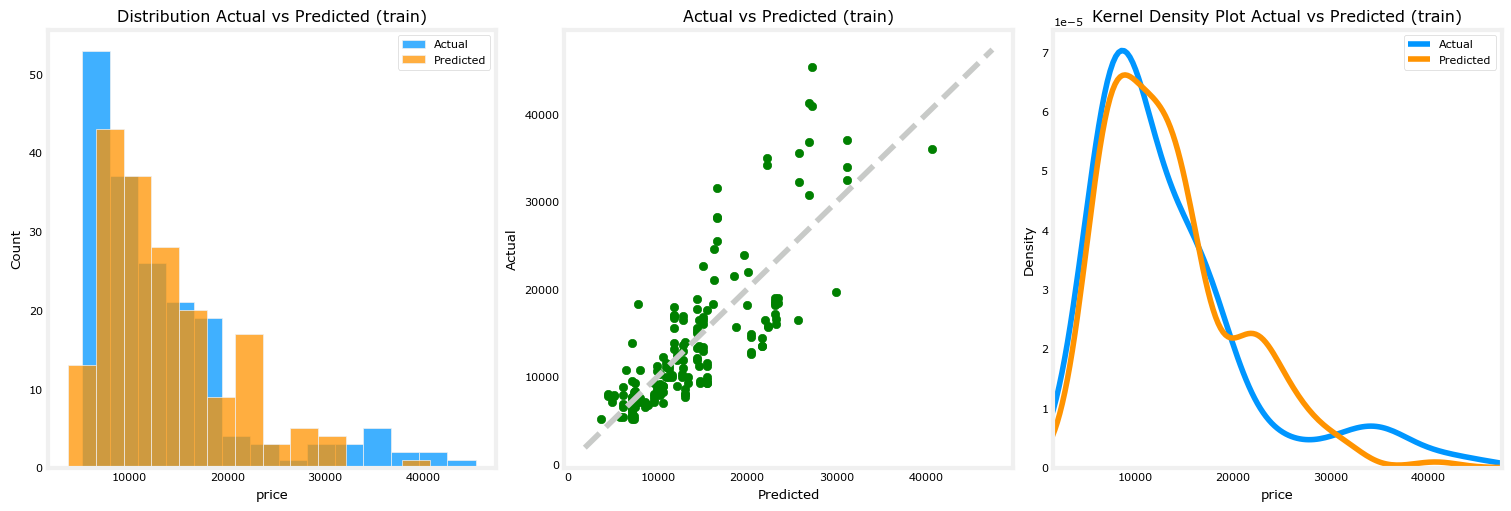

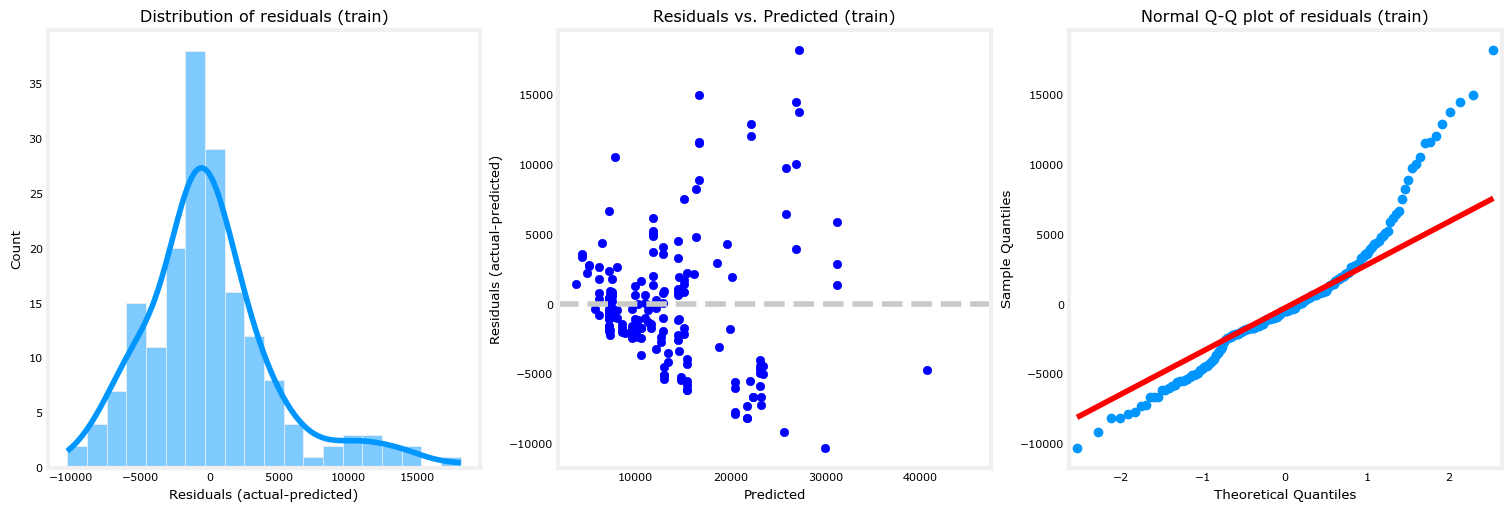

In [16]:
data_plotting.plot_actual_vs_predicted(y_train,y_pred_train,data_label='(train)')

Now let's plot actual vs predicted on test set.

R-squared:           0.3636
Mean Squared Error:  1.41e+07
Mean Absolute Error: 2.85e+03


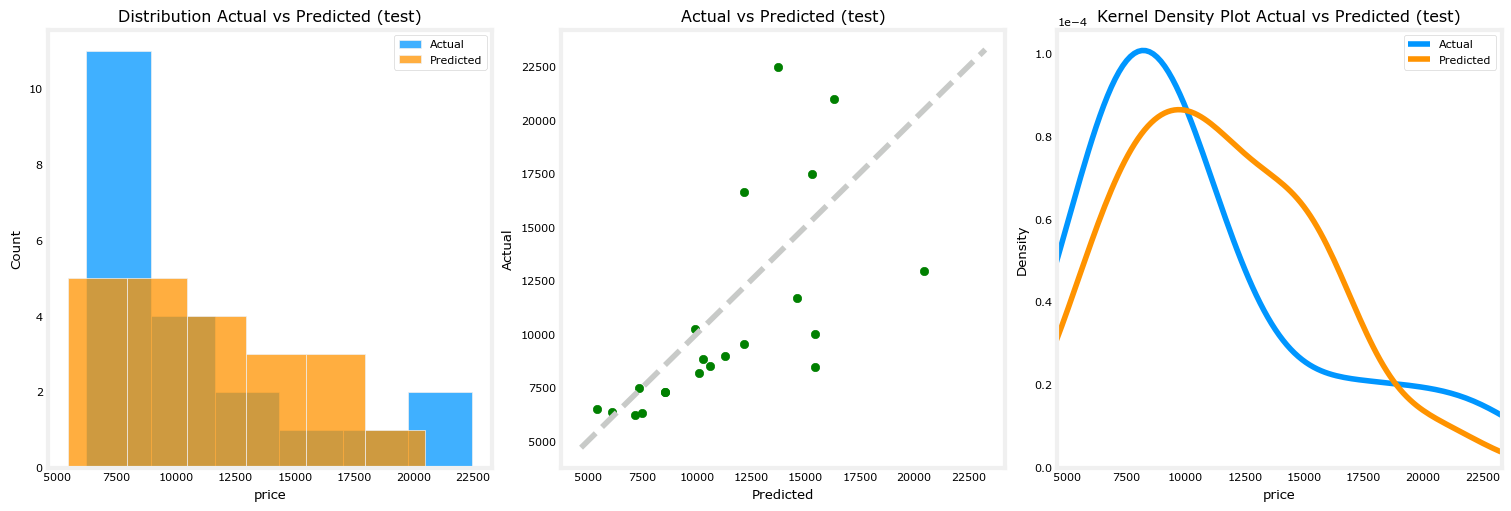

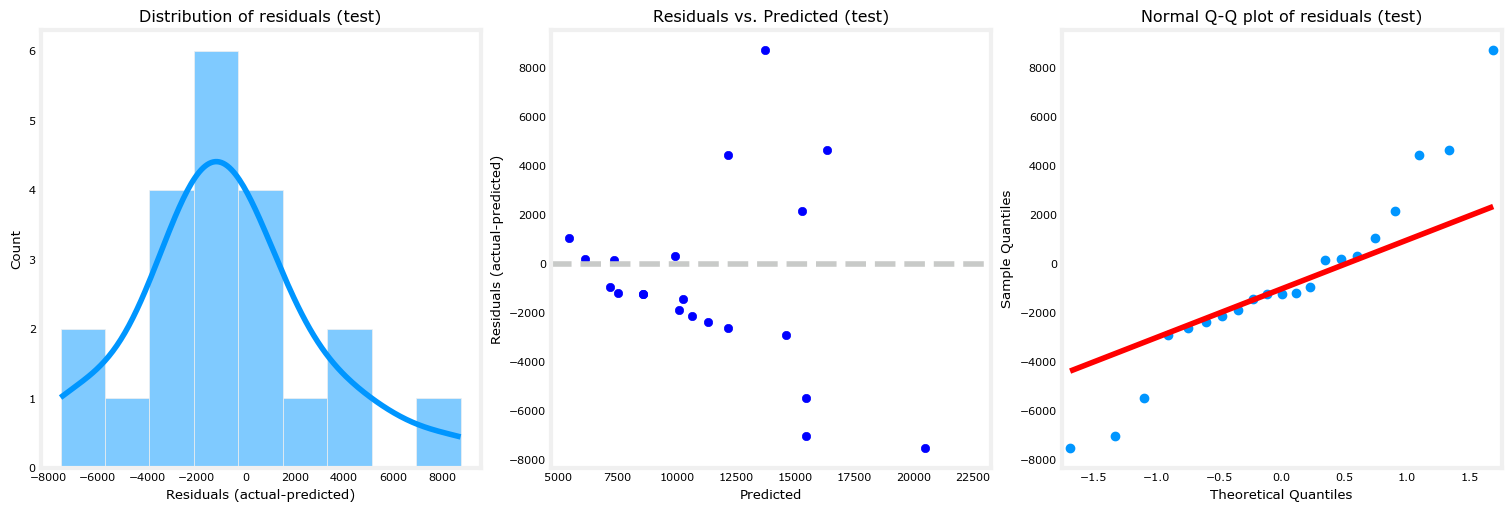

In [17]:
data_plotting.plot_actual_vs_predicted(y_test,y_pred_test,data_label='(test)')

From the above plots we see that our model perfomed much better on training set compared to the test set. Model is likely underfitting and not able to capture the complexity of the data.
Let's try polynomial regression with more features and see how that performs.

In [18]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']

pipe = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('lr',LinearRegression())])
pipe.set_params(pr__degree = 5).fit(X_train[features],y_train)


UsageError: unrecognized arguments: this prevents outputs from the cell (using it to prevent flowchart generation)


In [ ]:
y_pred_train = pipe.predict(X_train[features])
y_pred_test = pipe.predict(X_test[features])

In [ ]:
data_plotting.plot_actual_vs_predicted(y_train,y_pred_train,data_label='(train)')

Model has performed well on training set, let's see how it performs on test set.

In [ ]:
data_plotting.plot_actual_vs_predicted(y_test,y_pred_test,data_label='(test)')

R-squared is < 0 implies that this fit is poorer than just using mean of y as the predicted value. This model is overfitting the training data.
Let's see how R-squared evolves with degree of polynomial.

In [ ]:
r2_scores = []
for deg in range(1,11):
    pipe.set_params(pr__degree=deg).fit(X_train[features],y_train)
    y_pred_test = pipe.predict(X_test[features])
    r2_scores.append(r2_score(y_test,y_pred_test))

plt.plot(range(1,11),r2_scores,marker='o')
plt.ylabel('R-squared')
plt.xlabel('degree')
plt.title('R-squared vs degree of polynomial')
#plt.ylim(-1,1)
plt.show()
print(r2_scores[:5])

In [ ]:
# Let's check the coefficient values we got for all the polynomial features of degree 5
pipe.set_params(pr__degree=5).fit(X_test[features],y_test)
pipe.named_steps['lr'].coef_

We can see that at degree =5, r-squared value drops drastically. Model is heavily overfitting starting degree=5.

### <p id="rg">4. Avoiding overfitting (Regularization)</p>
Techniques like Ridge (applies L2 penaly) or Lasso (applies an L1 penalty) are both common ways to improve generalization and reduce overfitting. A well-tuned Ridge or Lasso often outperforms pure OLS when features are correlated, data is noisy, or sample size is small.

[Back to the top](#top)

#### Ridge Regression
sklearn's class Ridge allows for the user to specify that the solver (example gradient descent) be automatically chosen by setting solver="auto". When this option is "auto", Ridge will choose between the "lbfgs", "cholesky", and "sparse_cg" solvers based on certain [conditions](https://scikit-learn.org/stable/modules/linear_model.html#regression). 

Let's try ridge regression on polynomial features of degree 2. We will try different values for regularization parameter (called alpha).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']

pipe = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('scaler',StandardScaler()),('ridge', Ridge())])
# Let's start by setting alpha =1
pipe.set_params(pr__degree=2,ridge__alpha=1).fit(X_train[features],y_train)
y_pred_train = pipe.predict(X_train[features])
y_pred_test = pipe.predict(X_test[features])
pipe.get_params()


In [ ]:
# Let's perform cross validation on training data to get an idea of how the model is performing
scores = cross_val_score(pipe,X_train[features],y_train,cv=5,scoring='r2')
scores.mean(),scores.std()

In [ ]:
# evaluation on test set
r2_test = r2_score(y_test,y_pred_test)
r2_test

Now let's try different values of alpha and find the best value (the one that minimizes the cost function of the estimater or maximizes the scoring metric). It is best to choose the same scoring function as cost function for model training and as metric/score in model evaluation and comparison( [reference](https://scikit-learn.org/stable/modules/model_evaluation.html#which-scoring-function-should-i-use)). Ridge regression uses squared error as the loss function, so it is best to use R-squared or mean squared error as the scoring metric.

In [ ]:
alphas = np.logspace(-2,10,50)
r2_train = []
r2_test = []
for alpha in alphas:
    pipe.set_params(pr__degree=2,ridge__alpha=alpha).fit(X_train[features],y_train)
    y_pred_train = pipe.predict(X_train[features])
    y_pred_test = pipe.predict(X_test[features])
    cv_scores = cross_val_score(pipe,X_train[features],y_train,cv=5,scoring='r2')
    r2_train.append(cv_scores.mean())
    r2_test.append(r2_score(y_test,y_pred_test))
len(r2_train),len(r2_test)

In [ ]:
# plt.close()
%matplotlib inline
#%matplotlib widget
ax = plt.gca()
ax.plot(alphas,r2_train,marker='o', label='train')
ax.plot(alphas,r2_test,marker='o', label='test')
ax.axvline(x=84,label='best alpha',linestyle='--',color="#5F5C5C", linewidth=2)
ax.text(10,0,'x=84')
plt.xscale('log')
plt.title('R-squared vs regularization parameter(alpha)')
plt.xlabel('regularization parameter(alpha)')
plt.ylabel('R-squared')
plt.legend()
plt.show()



The best value of alpha seems to be 84

When alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero. On the other hand, as alpha tends toward zero and the solution tends towards the ordinary least squares, coefficients exhibit big oscillations. In practice it is necessary to tune alpha in such a way that a balance is maintained between both.

#### RidgeCV
Now, we will use sklearn's RidgeCV for trying various values of alpha and find the best alpha and best score. And we will compare with the results above.

In [ ]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)
pipe2 = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('scaler',StandardScaler()),('ridge', RidgeCV(scoring='r2'))])
pipe2.set_params(pr__degree=2,ridge__alphas=alphas).fit(X_train[features],y_train)

In [ ]:
pipe2.named_steps['ridge'].alpha_, pipe2.named_steps['ridge'].best_score_

The value of alpha chosen by RidgeCV is aligning with the plot we generated by doing all the steps manually.


In [ ]:
# Model coefficients, intercept and features
pipe2.named_steps['ridge'].coef_ ,pipe2.named_steps['ridge'].intercept_ , pipe2.named_steps['pr'].get_feature_names_out()

Now let's evaluate the model on the test set.

In [ ]:
y_pred_train = pipe2.predict(X_train[features])
y_pred_test = pipe2.predict(X_test[features])
reload(data_plotting)
data_plotting.plot_actual_vs_predicted(y_train,y_pred_train,data_label='(train)')

In [ ]:

data_plotting.plot_actual_vs_predicted(y_test,y_pred_test,data_label='(test)')

Based on the results above, we have got R-squared of 0.79 on test data and 0.78 on training data with CV. We also found that best alpha is about 83. And we kept degree of polynomial fixed to 2 while looking for the best value of alpha.

### <p id="gs1">5. GridSearchCV (using single scoring metric)</p>
Now what if we wanted to try various values of the degree of polynomial as well as to find the values that give us the best score. This can be implemented using sklearn's GridSearchCV.
The GridSearchCV instance implements the usual estimator API: when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter

[Back to the top](#top)

In [ ]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
# default scoring is neg mean squared error in RidgeCV, we are specifying it to be r2
# It is better to use RidgeCV with inbuilt CV rather than brute force way with Ridge
pipe3 = Pipeline([('pr',PolynomialFeatures(degree=1,include_bias=False)),('scaler',StandardScaler()),('ridge', RidgeCV(scoring='r2'))]) 
# let's define a grid of hyper parameters to be explored by GridSearchCV
# we are defining one grid (enclosed in {}) to be explored. there can be multiple grids
param_grid = [{
    'pr__degree':(2,3,4),
    'ridge__alphas':np.logspace(-6,6,13)
}]

grid_search = GridSearchCV(estimator=pipe3,
                           param_grid=param_grid,
                           cv=5, # splits can be randomized using cv = KFold(n_splits=5, shuffle=True, random_state=1)
                           scoring='r2')

grid_search.fit(X_train[features],y_train)


Note: we can also repeat above steps in a loop using the KFold with shuffle=True. so that we get a different randomization of data in each repetition. This will give us more generalization on training set.
Alternatively, we can use RepeatedKFold, which repeats KFold specified number of times with different randomization in each repetition.

In [ ]:
grid_search.best_params_, grid_search.best_score_,grid_search.best_estimator_

In [ ]:
best_params = grid_search.best_estimator_.get_params()
best_params

In [ ]:
# Scorer function used on the held out data to choose the best parameters for the model.
# The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
grid_search.scorer_, grid_search.best_index_

In [ ]:
# Let's look at result array, best_index_ above matches with the best ranked params below
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
# results_df = results_df.set_index(
# results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
# ).rename_axis("model")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head()

In [ ]:
# to get a generalized score on training set using cross validation on the final fitted model 
# given by grid_search
cv = KFold(n_splits=5,shuffle=True,random_state=1)
scores = cross_val_score(grid_search,X_train[features],y_train,cv=cv)
scores

In [ ]:
scores.mean(),scores.std()

In [ ]:
# Model accuracy evaluation on the test set
grid_search.score(X_test[features],y_test)


In [ ]:
y_pred_train = grid_search.predict(X_train[features])
y_pred_test = grid_search.predict(X_test[features])


In [ ]:
data_plotting.plot_actual_vs_predicted(y_train,y_pred_train,data_label='(train)')

In [ ]:
data_plotting.plot_actual_vs_predicted(y_test,y_pred_test,data_label='(test)')

### <p id="sig">Statistical Significance testing of GridSearchCV's top ranked estimators</p>
Based on the cv_results_ we saw that the estimator using 2nd degree polynomial features and regularization paramter alpha = 100 performed the best, closely followed by 2nd degree and alpha = 10. Usually the analysis ends here but half the story is missed. The output of GridSearchCV doesn't provide the information on the cetainty of the differences between the models. We don't know if these are **statistically significant**.

To evaluate this, we need to conduct a statistical test. To contrast the performance of two models we should statistically compare their R-squared scores. We need to have around 100 samples for each model. We get achieve this by using RepeatedKfold with n_repeats = 10 which uses different randomization in each repetition.

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html)

[Back to the top](#top)

In [ ]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)

param_grid = [{
    'pr__degree':(2,3,4),
    'ridge__alphas':np.logspace(-1,3,5)
}]
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=1) # 10 splits repeated 10 times = 100 samples for each model
grid_search2 = GridSearchCV(estimator=pipe3,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2')

grid_search2.fit(X_train[features],y_train)

In [ ]:
results_df = pd.DataFrame(grid_search2.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("param_comb")
results_df.head()

In [ ]:
# Let's inspect the results
reload(ds_modeling)
reload(data_plotting)
ds_modeling.GridSearchCV_results(grid_search2,cv,X_train[features],y_train,ranks_list=[1,2,3],run_ttest=False,plot_n_splits=30)


In [ ]:
ds_modeling.GridSearchCV_results(grid_search2,cv,X_train[features],y_train,ranks_list=[1,2,3],run_ttest=True,plot_score_by_split=False)

However, the scores of the models are not independent: all models are evaluated on the same 100 partitions, increasing the correlation between the performance of the models. Since some partitions of the data can make the distinction of the classes particularly easy or hard to find for all models, the models scores will co-vary.

Let’s inspect this partition effect by plotting the performance of all models in each fold, and calculating the correlation between models across folds:

In [ ]:
# create df of model scores ordered by performance
pd.set_option('display.max_columns', 7)
model_scores = results_df.filter(regex=f"split\d*_test_score")
#model_scores = model_scores.transpose()
model_scores.head()

In [ ]:
# Let's plot dependency between cv fold and r2_scores
fig, ax = plt.subplots()
sns.lineplot(
    data = model_scores.transpose().iloc[:30, :], # plot data for 30 rows i.e. 30 splits
    dashes=False,
    palette='Set2',
    ax=ax
)
plt.tick_params(bottom=True, labelbottom=False)
plt.xlabel('CV test fold')
plt.ylabel('R2_score')
plt.show()

In [ ]:
# print correlation coefficient of r2_score across folds
sns.heatmap(model_scores.transpose().corr(),annot=True)
plt.show()

We can observe that the performance of the models highly depends on the fold. And model performace is highly correlated.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist).

Several variance-corrected statistical tests have been developed for these cases. We will implement implement Nadeau and Bengio’s corrected t-test.

### <p id="tt">t-test (frequentist approach)</p>
Is the first model significantly better than the second model (when ranked by mean_test_score)?

Hypotheses for the population:
- Null H0: Mean test scores of both the models are equal 
- Alternative H1: Mean test score of model 1 is greater than model 2 implying that model 1 is better than model 2

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#comparing-two-models-frequentist-approach)

[Back to the top](#top)

In [ ]:

model_1_scores = model_scores.iloc[0].values # scores of the best model
model_2_scores = model_scores.iloc[1].values # scores of second best model
ds_modeling.GridSearchCV_ttest(model_1_scores, model_2_scores,cv,X_train[features],y_train)

p-value is not < 0.05, so we cannot confirm that model 1 is better than model 2. This approach (frequentist) doesn't let us confirm H0 that both are models have an equivalent performance. If we wanted to make this assertion, we need to use Bayesian approach.
For classifiers use this [method](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#comparing-two-models-bayesian-approach)

I am unaware of what method to use for regression at this point.

### <p id="pc">Pairwise comparison of all models (frequentist approach)</p>
We could also be interested in comparing the performance of all our models evaluated with GridSearchCV. In this case we would be running our statistical test multiple times, which leads us to the multiple comparisons problem.

There are many possible ways to tackle this problem, but a standard approach is to apply a Bonferroni correction. Bonferroni can be computed by multiplying the p-value by the number of comparisons we are testing.

Let’s compare the performance of the models using the corrected t-test

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#pairwise-comparison-of-all-models-frequentist-approach)

[Back to the top](#top)

In [ ]:
reload(ds_modeling)
ds_modeling.GridSearchCV_pairwise_ttest(model_scores.iloc[:5],cv,X_train[features],y_train)

### <p id="time">Trade-off between scoring time and mean test score</p>

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py)

[Back to the top](#top)

In [ ]:
def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = pd.DataFrame(grid_search2.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)



param_names = [shorten_param(name) for name in param_grid[0].keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (R-squared)",
}
fig = px.scatter(
    cv_results,
    x="mean_score_time",
    y="mean_test_score",
    error_x="std_score_time",
    error_y="std_test_score",
    hover_data=param_names,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "trade-off between scoring time and mean test score",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

Models in the upper-left corner of the plot would have the best trade-off between accuracy and scoring time. In this data set, we don't see much variation.

### <p id="pl">Visualize mean test score as a function of the tuned hyperparameters</p>
This helps finding interactions between more than two hyperparameters and provide intuition on their relevance for improving the performance of a pipeline.

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py)

[Back to the top](#top)

In [ ]:
param_names

In [ ]:


column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)
print(transform_funcs)
# Using a logarithmic scale for alpha
transform_funcs["alphas"] = math.log10

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "Parallel coordinates plot",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

The parallel coordinates plot displays the values of the hyperparameters on different columns while the performance metric is color coded. It is possible to select a range of results by clicking and holding on any axis of the parallel coordinate plot. You can then slide (move) the range selection and cross two selections to see the intersections. You can undo a selection by clicking once again on the same axis.

### <p id="gs2">6. GridSearchCV (using two scoring metrics)</p>

Scoring parameter of GridSearchCV: Multimetric scoring can either be specified as a list of strings of predefined scores names or a dict mapping the scorer name to the scorer function and/or the predefined scorer name(s)

Note: When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. If the search should not be refit, set refit=False. Leaving refit to the default value None will result in an error when using multiple metrics.

[Back to the top](#top)

In [ ]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
# default scoring is neg mean squared error in RidgeCV, we are specifying it to be r2
# It is better to use RidgeCV with inbuilt CV rather than brute force way with Ridge
pipe3 = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('scaler',StandardScaler()),('ridge', RidgeCV())]) 
# let's define a grid of hyper parameters to be explored by GridSearchCV
# we are defining one grid (enclosed in {}) to be explored. there can be multiple grids
param_grid = [{
    'pr__degree':(2,3,4),
    'ridge__alphas':np.logspace(-2,2,5)
}]
scoring = {
    'Rsquared' : 'r2',
    'negMAE'   : 'neg_mean_absolute_error'

}
#  splits with 10 randomized repeats and 10 folds, generating 100 samples for each model
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=0)
# Setting refit='Rsquared', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated Rsquared score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(estimator=pipe3,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=scoring,
                           refit='Rsquared',
                           return_train_score=True)

gs.fit(X_train[features],y_train)


In [ ]:
results = gs.cv_results_

In [ ]:
gs.best_params_, gs.best_score_, gs.scorer_

Based on the result above, the best model is with 2nd degree polynomial and regularization parameter of 100.0 in Ridge regression. Something to keep in mind is these best parameters are based on the scoring metric we defined for refit i.e. R-squared.

### <p id="trade">Trade-off between the two scoring metrics</p>
Let's plot both the scores against one hyperparameter.

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html)

In [ ]:

dlblue = '#0096ff'; dlorange = '#FF9300'
# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_pr__degree"].data, dtype=float)
sample_score_mean = {}
sample_score_std = {}
for scorer, color in zip(sorted(scoring), ["g", "k"]):
    sample_score_mean[scorer] = {}
    sample_score_std[scorer] = {}
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean[scorer][sample] = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std[scorer][sample] = results["std_%s_%s" % (sample, scorer)]

# Create figure and primary y-axis
fig, ax1 = plt.subplots()
# Plot first dataset on primary y-axis
ax1.plot(X_axis, sample_score_mean['Rsquared']['test'], 'o', color=dlblue, label='Rsquared(test)')
ax1.set_xlabel('degree of polynomial')
ax1.set_ylabel('Rsquared', color=dlblue)
ax1.tick_params(axis='y', labelcolor=dlblue)

# Create secondary y-axis and plot second dataset
ax2 = ax1.twinx()
ax2.plot(X_axis, sample_score_mean['negMAE']['test'],'o',color= dlorange, label='negMAE(test)')
ax2.set_ylabel('negMAE', color=dlorange)
ax2.tick_params(axis='y', labelcolor=dlorange)

# Add title and legends
fig.suptitle('Rsquared vs negMAE vs deg of Polynomial')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(X_axis)
#plt.xscale('log')
# Display the plot
plt.show()   

Note: We are 5 dots of each color for each degree of polynomial because we have 5 alpha values we are trying.

What if we want to take into account both the scoring metrics we measured in the GridSearchCV?

We can process the results from GridSearchCV with a customized strategy to get the best parameter combination. Let's do that next.

### <p id="gsc">GridSearchCV: Custom starategy to find the best model</p>
The strategy is to short-list the models which are the best in terms of R-squared and least in MAE
as used in GridSearchCV. And then choose fastest amongst those.
Step1: We use a threshold value to filter models for R-squared and 
Step2: we filter for metric_2 by choosing models within 1 stdev of max of neg MAE. 
Step3: we apply the final filter to get the fastest of all.

[reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)

[Back to the top](#top)

In [ ]:
reload(ds_modeling)
ds_modeling.custom_strategy_for_best_estimator(gs.cv_results_,'Rsquared', 'negMAE', threshold_scorer_1 = 0.6)

Best index is 7 as per the result above. Let's more columns of this index.

In [ ]:
pd.options.display.max_rows = None
df = pd.DataFrame(gs.cv_results_)
print(df.loc[7].drop(df.filter(regex='split*').columns))
df.shape

Based on this strategy, above table gives us the best params combination.

### <p id="bv">7. Optimizing for Bias and Variance (Validation Curve, Learning Curve)</p>

#### Validation Curve
The proper way of choosing multiple hyperparameters of an estimator is of course grid search or similar methods.
However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

Note: We can only do this for one hyperparameter at a time, keeping others fixed. Run CV and get training and test scores (mean, stdev) for each value of the parameter. Then we plot the mean test scores and show the +- 1 stdev using fill_between.

[reference](https://scikit-learn.org/stable/modules/learning_curve.html)

[Back to the top](#top)

We can generate this curve using the following functions from sklearn:
1. validation_curve (this is similar to grid search with one parameter) along with manual plotting or 
2. ValidationCurveDisplay that automatically plots

We will do it using GridSearchCV first (not recommended because we are only tuning one hyperparameter) just to see how the plot gets generated.
##### Using GridSearchCV (not recommended for this purpose)

In [ ]:
%%capture # this prevents outputs from the cell (using it to prevent flowchart generation)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
# RidgeCV is better than using GridSearchCV when we are only tuning the alpha as the hyperparameter
# But in out scenario we have other hyperparameters in the pipeline with preprocessing
# So we need to use GridSearchCV
pipe3 = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('scaler',StandardScaler()),('ridge', Ridge())]) 
# let's define a grid of hyper parameters to be explored by GridSearchCV
# we are defining one grid (enclosed in {}) to be explored. there can be multiple grids
param_grid = [{
#    'pr__degree':(1,2,3,4),
    'ridge__alpha':np.logspace(-6,6,13)
}]

#  splits with 10 randomized repeats and 10 folds, generating 100 samples for each model
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=0)

gs3 = GridSearchCV(estimator=pipe3,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2',
                           return_train_score=True)

gs3.fit(X_train[features],y_train)

In [ ]:
results = pd.DataFrame(gs3.cv_results_)
results.head()

In [ ]:
model_scores = results.filter(regex=r'(param_|mean.*score|std.*score).*')
model_scores.columns

In [ ]:
sns.lineplot(data=model_scores,x='param_ridge__alpha',y='mean_train_score',errorbar=None,label='train')
sns.lineplot(data=model_scores,x='param_ridge__alpha',y='mean_test_score',errorbar=None,label='test')

ax = plt.gca()
ax.fill_between(
    model_scores['param_ridge__alpha'],
    model_scores['mean_test_score'] - model_scores['std_test_score'],
    model_scores['mean_test_score'] + model_scores['std_test_score'],
    alpha=0.4,
    color = dlorange
)
ax.fill_between(
    model_scores['param_ridge__alpha'],
    model_scores['mean_train_score'] - model_scores['std_train_score'],
    model_scores['mean_train_score'] + model_scores['std_train_score'],
    alpha=0.1,
    color = dlblue
)
plt.xticks(model_scores['param_ridge__alpha'])
plt.legend()
plt.xscale('log')
plt.xticks(model_scores['param_ridge__alpha'])
plt.show()

If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible.

Now we will generate the same curve using ValidationCurveDisplay
##### Using ValidationCurveDisplay (recommended)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
pipe3 = Pipeline([('pr',PolynomialFeatures(include_bias=False)),('scaler',StandardScaler()),('ridge', Ridge())])
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=0)

param_grid = [{
    'pr__degree':(1,2,3,4),
    'ridge__alpha':np.logspace(-6,6,13)
}]
param_name = 'pr__degree'
ValidationCurveDisplay.from_estimator(
   pipe3, X_train[features],y_train, param_name=param_name, param_range=param_grid[0][param_name],cv=cv,scoring='r2'
)
plt.show()

In [ ]:
param_name = 'ridge__alpha'
ValidationCurveDisplay.from_estimator(
   pipe3, X_train[features],y_train, param_name=param_name, param_range=param_grid[0][param_name],cv=cv,scoring='r2'
)
plt.show()

### Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

If both the validation score and the training score converge to a value that is quite low with increasing size of the training set, we will probably not benefit much from more training data.

In contrast, if for small amounts of data, the training score is much greater than the validation score. Adding more training samples will most likely increase generalization.

[reference](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve)

[Back to the top](#top)   

Method 1:
We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets). Then we will manually plot the data.

Method 2:
To plot the learning curves automaically, the class LearningCurveDisplay will be easier to use.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
pipe3 = Pipeline([('pr',PolynomialFeatures(degree=2,include_bias=False)),('scaler',StandardScaler()),('ridge', Ridge(alpha=100.0))])
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=0)

train_sizes=[10, 80, 110,140]

LearningCurveDisplay.from_estimator(
   pipe3, X_train[features],y_train, train_sizes = train_sizes,cv=cv,scoring='r2'
)
plt.show()